In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from glob import glob
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tqdm import tqdm
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = "1,2"

train_val_df = pd.read_csv("../../data/train_val.csv")
test_df = pd.read_csv("../../data/test.csv")

# Extract the paths and labels
disease_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'No Finding']
train_val_labels = train_val_df[disease_labels].values
test_labels = test_df[disease_labels].values

In [2]:
train_val_df['Paths'] = train_val_df['Paths'].apply(lambda x : x.split("../../../")[1])
test_df['Paths'] = test_df['Paths'].apply(lambda x : x.split("../../../")[1])

## random sample

In [3]:
len(train_val_df)

86523

In [4]:
# import random

# train_val_df = train_val_df.sample(frac=0.1, replace=True, random_state=1)
# test_df = test_df.sample(frac=0.1, replace=True, random_state=1)

# print("train_val_df length : ", len(train_val_df))
# print("test_df length : ", len(test_df))

In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, labels, transform=None):
        self.dataframe = dataframe
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.dataframe.iloc[idx]['Paths'])
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_val_dataset = CustomDataset(train_val_df, train_val_labels, transform=transform)
test_dataset = CustomDataset(test_df, test_labels, transform=transform)

train_loader = DataLoader(train_val_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


In [6]:
import torch.nn as nn
import torchvision.models as models

class ResNetModified(nn.Module):
    def __init__(self):
        super(ResNetModified, self).__init__()
        original_model = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 15),
            nn.Sigmoid()  # Sigmoid for multi-label classification
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetModified()

model = nn.DataParallel(model)
model = model.to(device)


/userHome/userhome4/seungyeon/miniconda3/envs/nih_syn/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/userHome/userhome4/seungyeon/miniconda3/envs/nih_syn/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
## 20시간 걸림 (1207m)

# criterion = nn.BCELoss()  # Binary Cross Entropy Loss
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# num_epochs = 20

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for images, labels in tqdm(train_loader, desc=f"Train_loader Epoch: {epoch}"):
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

#     # Evaluate the model
#     model.eval()
#     all_labels = []
#     all_outputs = []
#     with torch.no_grad():
#         for images, labels in tqdm(test_loader, desc=f"Test_loader Epoch: {epoch}"):
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             all_labels.append(labels.cpu().numpy())
#             all_outputs.append(outputs.cpu().numpy())

#     all_labels = np.vstack(all_labels)
#     all_outputs = np.vstack(all_outputs)
#     all_outputs = (all_outputs > 0.5).astype(int)

#     accuracy = accuracy_score(all_labels, all_outputs)
#     roc_auc = roc_auc_score(all_labels, all_outputs)
#     f1 = f1_score(all_labels, all_outputs, average='macro')

#     print(f"Accuracy: {accuracy}, F1-Score: {f1}, Roc_Auc: {roc_auc}")


# root_save_path = "save"
# if not os.path.exists(root_save_path):
#     os.makedirs(root_save_path)
    
# model_save_path =os.path.join(root_save_path, "resnet_modified.pth")

# # Save the model
# torch.save(model.state_dict(), model_save_path)


In [8]:
model_weight_path = torch.load("save/resnet_modified.pth")
model.load_state_dict(model_weight_path)

<All keys matched successfully>

In [9]:
# 20분 걸림 (20m)
def evaluate_and_save_results(model, test_loader, threshold=0.5):
    model.eval()
    all_labels = []
    all_outputs = []
    all_filenames = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Test Loader"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())
            all_filenames.extend(test_loader.dataset.dataframe.iloc[:len(images)]['Paths'].tolist())

    all_labels = np.vstack(all_labels)
    all_outputs = np.vstack(all_outputs)
    binary_outputs = (all_outputs > threshold).astype(int)

    results_df = pd.DataFrame({
        'filename': all_filenames,
        'true_labels': list(all_labels),
        'predicted_labels': list(binary_outputs),
        'predicted_probabilities': list(all_outputs)
    })

    results_df.to_csv('evaluation_results.csv', index=False)

    accuracy = accuracy_score(all_labels, binary_outputs)
    # precision = precision_score(all_labels, binary_outputs, average='micro')
    # recall = roc_auc_score(all_labels, binary_outputs)
    f1 = f1_score(all_labels, binary_outputs, average='micro')
    roc_auc_macro = roc_auc_score(all_labels, all_outputs, average='macro')

    print(f"Accuracy: {accuracy}, F1-Score: {f1}, ROC_AUC:  {roc_auc_macro}")
    
    return all_labels, all_outputs, binary_outputs

# Evaluate the model and save results
all_labels, all_outputs, binary_outputs = evaluate_and_save_results(model, test_loader, threshold=0.5)


Accuracy: 0.265403399101387, F1-Score: 0.34749143035213464, ROC_AUC:  0.6846809914960004


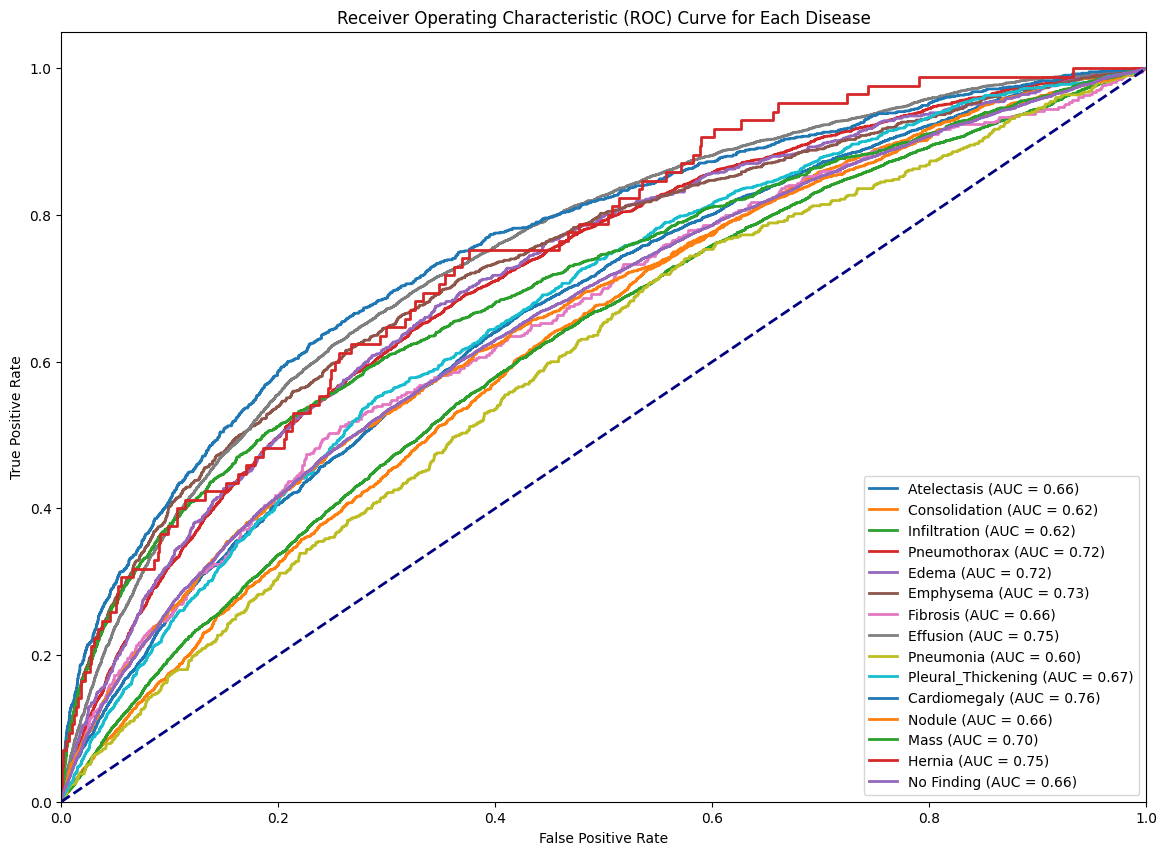

Atelectasis - ROC AUC Score: 0.6645
Consolidation - ROC AUC Score: 0.6244
Infiltration - ROC AUC Score: 0.6186
Pneumothorax - ROC AUC Score: 0.7155
Edema - ROC AUC Score: 0.7160
Emphysema - ROC AUC Score: 0.7337
Fibrosis - ROC AUC Score: 0.6580
Effusion - ROC AUC Score: 0.7485
Pneumonia - ROC AUC Score: 0.5974
Pleural_Thickening - ROC AUC Score: 0.6706
Cardiomegaly - ROC AUC Score: 0.7587
Nodule - ROC AUC Score: 0.6556
Mass - ROC AUC Score: 0.7032
Hernia - ROC AUC Score: 0.7467
No Finding - ROC AUC Score: 0.6589
Overall Accuracy: 0.7794


In [14]:
from sklearn.metrics import roc_auc_score, roc_curve, auc


# Plot ROC curve for each class
plt.figure(figsize=(14, 10))
for i, disease in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(all_labels[:, i], all_outputs[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{disease} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Disease')
plt.legend(loc='lower right')
plt.show()

# Print ROC AUC scores for each class
for i, disease in enumerate(disease_labels):
    roc_auc_label = roc_auc_score(all_labels[:, i], all_outputs[:, i])
    print(f'{disease} - ROC AUC Score: {roc_auc_label:.4f}')
    
# Calculate overall accuracy
overall_accuracy = roc_auc_score(all_labels.reshape(-1), all_outputs.reshape(-1))
print(f'Overall Accuracy: {overall_accuracy:.4f}')    


## 개별 스코어 값

In [18]:
# 정확도 및 F1 스코어 계산
accuracy = accuracy_score(all_labels, binary_outputs)
f1_micro = f1_score(all_labels, binary_outputs, average='micro')
f1_macro = f1_score(all_labels, binary_outputs, average='macro')

for idx in range(all_labels.shape[1]):
    accuracy_label = accuracy_score(all_labels[:, idx], binary_outputs[:, idx])
    print(f"Class {idx} - Accuracy: {accuracy_label}, F1 Score(macro): {f1_macro}, F1 Score(micro): {f1_micro}")

Class 0 - Accuracy: 0.813322914631764, F1 Score(macro): 0.1682171649805943, F1 Score(micro): 0.34749143035213464
Class 1 - Accuracy: 0.9143973432310998, F1 Score(macro): 0.1682171649805943, F1 Score(micro): 0.34749143035213464
Class 2 - Accuracy: 0.728892361789412, F1 Score(macro): 0.1682171649805943, F1 Score(micro): 0.34749143035213464
Class 3 - Accuracy: 0.8918538777104903, F1 Score(macro): 0.1682171649805943, F1 Score(micro): 0.34749143035213464
Class 4 - Accuracy: 0.9575307677280719, F1 Score(macro): 0.1682171649805943, F1 Score(micro): 0.34749143035213464
Class 5 - Accuracy: 0.9530767728071889, F1 Score(macro): 0.1682171649805943, F1 Score(micro): 0.34749143035213464
Class 6 - Accuracy: 0.9823793709708928, F1 Score(macro): 0.1682171649805943, F1 Score(micro): 0.34749143035213464
Class 7 - Accuracy: 0.7769486227778863, F1 Score(macro): 0.1682171649805943, F1 Score(micro): 0.34749143035213464
Class 8 - Accuracy: 0.9779253760500097, F1 Score(macro): 0.1682171649805943, F1 Score(micr

# 각 loss 계산 결과

In [23]:
all_labels, all_outputs
# Cell 1: Import necessary libraries
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, coverage_error, label_ranking_loss, average_precision_score

# Assuming 'all_labels' and 'ensemble_preds' are already defined and have compatible shapes
# Convert ensemble probabilities to class predictions using a threshold (e.g., 0.5)
threshold = 0.5
all_outputs_pred = binary_outputs

# Define the disease labels
disease_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'No Finding']

# Calculate accuracy for each class
print("Accuracy for each class:")
for i, disease in enumerate(disease_labels):
    accuracy_class = accuracy_score(all_labels[:, i], all_outputs_pred[:, i])
    print(f'{disease} - Accuracy: {accuracy_class:.4f}')

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels.reshape(-1), all_outputs_pred.reshape(-1))
print(f'Overall Accuracy: {overall_accuracy:.4f}')

print("all_labels.shape : ", all_labels.shape)

# Calculate overall accuracy before reshape
overall_accuracy_bf_reshape = accuracy_score(all_labels, all_outputs_pred)
print(f'Overall Accuracy before reshape: {overall_accuracy_bf_reshape:.4f}')


Accuracy for each class:
Atelectasis - Accuracy: 0.8133
Consolidation - Accuracy: 0.9144
Infiltration - Accuracy: 0.7289
Pneumothorax - Accuracy: 0.8919
Edema - Accuracy: 0.9575
Emphysema - Accuracy: 0.9531
Fibrosis - Accuracy: 0.9824
Effusion - Accuracy: 0.7769
Pneumonia - Accuracy: 0.9779
Pleural_Thickening - Accuracy: 0.9530
Cardiomegaly - Accuracy: 0.9572
Nodule - Accuracy: 0.9262
Mass - Accuracy: 0.9121
Hernia - Accuracy: 0.9962
No Finding - Accuracy: 0.6229
Overall Accuracy: 0.8909
all_labels.shape :  (25595, 15)
Overall Accuracy before reshape: 0.2654


In [24]:
# Cell 2: Calculate Hamming Loss
hamming_loss_value = hamming_loss(all_labels, all_outputs_pred)
print(f'Hamming Loss: {hamming_loss_value:.4f}')


Hamming Loss: 0.1091


In [26]:
# Cell 3: Calculate Ranking Loss
ranking_loss_value = label_ranking_loss(all_labels, all_outputs_pred)
print(f'Ranking Loss: {ranking_loss_value:.4f}')


Ranking Loss: 0.6550


In [29]:
# Cell 4: Calculate Multilabel Accuracy
accuracy_each_class = []

# Calculate accuracy for each class
for i, disease in enumerate(disease_labels):
    accuracy_each_class.append(accuracy_score(all_labels[:, i], all_outputs_pred[:, i]))

multilabel_accuracy = np.average(accuracy_each_class)
print(f'Multilabel Accuracy: {multilabel_accuracy:.4f}')


Multilabel Accuracy: 0.8909


In [31]:
# Cell 5: Calculate Multilabel Coverage
multilabel_coverage = coverage_error(all_labels, all_outputs_pred)
print(f'Multilabel Coverage: {multilabel_coverage:.4f}')


Multilabel Coverage: 10.8886


In [33]:
# Cell 6: Calculate One Error
def one_error(y_true, y_pred):
    n_samples = y_true.shape[0]
    one_error_count = 0
    for i in range(n_samples):
        top_pred_idx = np.argmax(y_pred[i])
        if y_true[i, top_pred_idx] == 0:
            one_error_count += 1
    return one_error_count / n_samples

one_error_value = one_error(all_labels, all_outputs_pred)
print(f'One Error: {one_error_value:.4f}')

One Error: 0.6072


In [34]:
# Cell 7: Calculate Subset Accuracy
subset_accuracy = accuracy_score(all_labels, all_outputs_pred, normalize=True)
print(f'Subset Accuracy: {subset_accuracy:.4f}')


Subset Accuracy: 0.2654


In [35]:
# Cell 8: Calculate Macro F1 Score
macro_f1_score = f1_score(all_labels, all_outputs_pred, average='macro')
print(f'Macro F1 Score: {macro_f1_score:.4f}')


Macro F1 Score: 0.1682


In [36]:
# Cell 9: Calculate Micro F1 Score
micro_f1_score = f1_score(all_labels, all_outputs_pred, average='micro')
print(f'Micro F1 Score: {micro_f1_score:.4f}')


Micro F1 Score: 0.3475


In [48]:
# Record each class accuracy
columns = disease_labels

for i,v in enumerate(accuracy_each_class):
    accuracy_each_class[i] = f"{v:.4f}"

result = pd.DataFrame([accuracy_each_class], columns=columns)
result.to_csv("each_class_accuracy.csv", index=False)

: 

In [47]:
# Record over all loss
columns = [
    "Hamming Loss",
    "Ranking Loss",
    "Multilabel Accuracy",
    "Multilabel Coverage",
    "One Error",
    "Subset Accuracy",
    "Macro F1 score",
    "Micro F1 score"
]

over_score=[]

over_score.append(f"{hamming_loss_value:.4f}")
over_score.append(f"{ranking_loss_value:.4f}")
over_score.append(f"{multilabel_accuracy:.4f}")
over_score.append(f"{multilabel_coverage:.4f}")
over_score.append(f"{one_error_value:.4f}")
over_score.append(f"{subset_accuracy:.4f}")
over_score.append(f"{macro_f1_score:.4f}")
over_score.append(f"{micro_f1_score:.4f}")

result = pd.DataFrame([over_score], columns=columns)
result.to_csv("overall_score.csv", index=False)